# Análise de preços das ações das empresas AMD, ASUS, Intel, MSI, NVIDIA

---


Vamos analisar os DataFrames das seguintes empresas: AMD, ASUS, INTEL, MSI, NVIDIA. Ver o comportamento delas ao longo dos anos. 

As colunas do DataFrames estão organizadas da seguinte forma:

* Date: Data (AAAA-MM-DD)

* Open: O valor que a ação abriu o dia

* High: O maior valor que ela atingiu no dia

* Low: O menor valor que ela atingiiu no dia

* Close: O valor que a ação fechou o dia

* Adj Close: "Adjusted Close" preço de fechamento ajustado.

* Volume: Volume de ações negociadas.

In [ ]:
df = pd.merge(amd, asus, how='outer', on='Date')
df = pd.merge(df, intel, how='outer', on='Date')
df = pd.merge(df, msi, how='outer', on='Date')
df = pd.merge(df, nvidia, how='outer', on='Date')
df

# 2000 - 2023
start_date = '2000-01-01'
end_date = '2023-04-17'
amd_2000 = filter_df(amd, start_date, end_date)
asus_2000 = filter_df(asus, start_date, end_date)
intel_2000 = filter_df(intel, start_date, end_date)
msi_2000 = filter_df(msi, start_date, end_date)
nvidia_2000 = filter_df(nvidia, start_date, end_date)
#  drawing line plot
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=amd_2000, x="Date", y="Adj Close", label='AMD')
sns.lineplot(data=asus_2000, x="Date", y="Adj Close", label="ASUS")
sns.lineplot(data=intel_2000, x="Date", y="Adj Close", label="INTEL")
sns.lineplot(data=msi_2000, x="Date", y="Adj Close", label="MSI")
sns.lineplot(data=nvidia_2000, x="Date", y="Adj Close", label="NVIDIA")
ax.legend(title='Companies')


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

amd = pd.read_csv("AMD (1980-2023).csv", parse_dates=['Date'])
asus = pd.read_csv("ASUS (2000-2023).csv", parse_dates=['Date'])
intel = pd.read_csv("Intel (1980-2023).csv", parse_dates=['Date'])
msi = pd.read_csv("MSI (1962-2023).csv", parse_dates=['Date'])
nvidia = pd.read_csv("NVIDIA (1999-2023).csv", parse_dates=['Date'])

In [2]:
def filter_df(df, start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    df_filtered = df[(df.Date >= start_date) & (df.Date <= end_date)]
    return df_filtered

In [10]:
amd

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200
1,1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200
2,1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600
3,1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800
4,1980-03-24,0.000000,2.916667,2.635417,2.666667,2.666667,436800
...,...,...,...,...,...,...,...
10854,2023-04-05,94.349998,94.500000,91.360001,92.559998,92.559998,52979300
10855,2023-04-06,91.470001,92.910004,90.620003,92.470001,92.470001,47778400
10856,2023-04-10,91.320000,95.800003,91.019997,95.480003,95.480003,52536300
10857,2023-04-11,96.059998,96.070000,92.690002,94.029999,94.029999,51935800


In [3]:
start_date = '2000-01-01'
end_date = '2023-04-17'

df_list = [amd, asus, intel, msi, nvidia]

df_list_filtered = []

for df in df_list:
    df_filtered = filter_df(df, start_date, end_date)
    df_list_filtered.append(df_filtered)

amd_2000, asus_2000, intel_2000, msi_2000, nvidia_2000 = df_list_filtered


[Text(0.5, 0, 'Date'),
 Text(0, 0.5, 'Price Close'),
 Text(0.5, 1.0, 'Movimet Stock Price (2000-2023)')]

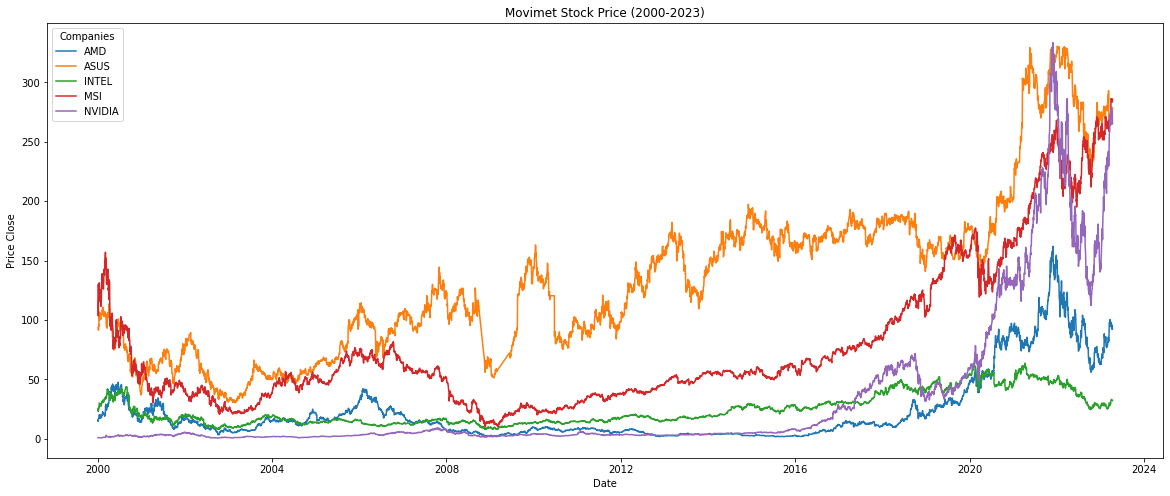

In [4]:
# price plot
labels = ['AMD', 'ASUS', 'INTEL', 'MSI', 'NVIDIA']
fig, ax = plt.subplots(figsize=(20,8))
for i,df in enumerate(df_list_filtered):
    sns.lineplot(data=df, x="Date", y="Adj Close", label=labels[i])

ax.legend(title="Companies")
ax.set(xlabel='Date', ylabel='Price Close', title='Movimet Stock Price (2000-2023)')

>Aqui podemos observar que a ASUS sempre esteve em alta ao longo dos anos e em 2020 ela caiu como a maioria das empresas, provavelmente por conta da pandemia do COVID-19.

>Podemos notar também que a empresa MSI teve grande evolução a partir de 2016 e se encontra hoje entre as com maior valor de ação.

>A empresa NVIDIA se desenvolveu muito no período de pandemia e assumindo o lugar entre as 3 com maior valor de ação.

In [28]:
nvidia_2020 = filter_df(nvidia, '2021-01-01', '2023-04-17')
nvidia_2020['Month'] = nvidia_2020['Date'].apply(lambda date: date.strftime('%Y-%m'))
nvidia_2020

C:\Users\jeanm\AppData\Local\Temp\ipykernel_3924\2768086345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_2020['Month'] = nvidia_2020['Date'].apply(lambda date: date.strftime('%Y-%m'))


,Date,Open,High,Low,Close,Adj Close,Volume,Month
5522,2021-01-04,131.042496,136.524994,129.625000,131.134995,130.875916,56064000,2021-01
5523,2021-01-05,130.997498,134.434998,130.869995,134.047501,133.782669,32276000,2021-01
5524,2021-01-06,132.225006,132.449997,125.860001,126.144997,125.895790,58042400,2021-01
5525,2021-01-07,129.675003,133.777496,128.865005,133.440002,133.176392,46148000,2021-01
5526,2021-01-08,133.625000,134.210007,130.419998,132.767502,132.505219,29252800,2021-01
...,...,...,...,...,...,...,...,...
6089,2023-04-05,268.290009,269.980011,263.950012,268.809998,268.809998,51501500,2023-04
6090,2023-04-06,265.839996,270.799988,264.269989,270.369995,270.369995,39765400,2023-04
6091,2023-04-10,268.230011,276.209991,266.690002,275.790009,275.790009,39527900,2023-04
6092,2023-04-11,277.239990,277.899994,271.260010,271.690002,271.690002,31437800,2023-04


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

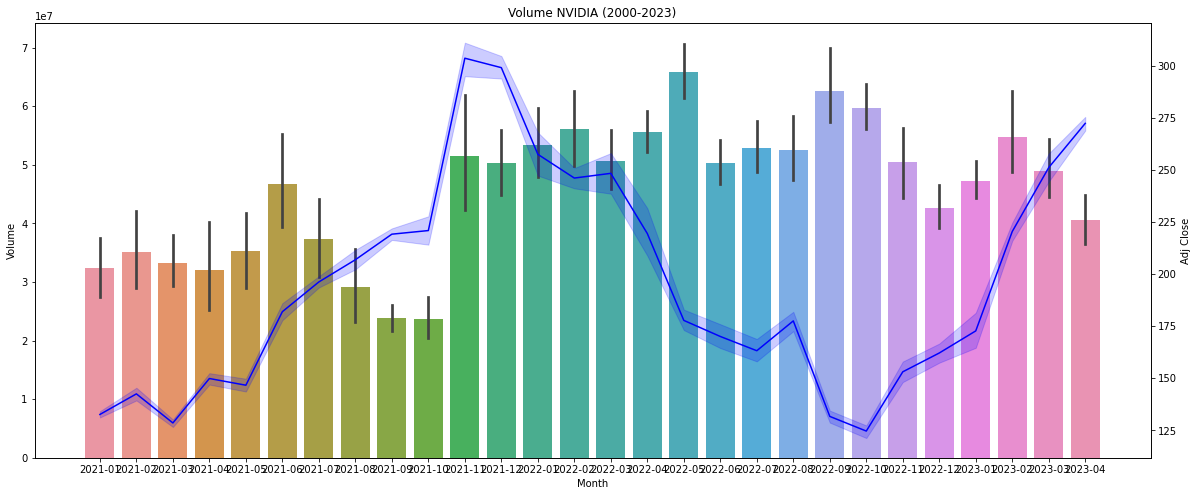

In [33]:
# volume plot NVIDIA


fig, ax1 = plt.subplots(figsize=(20,8))

sns.barplot(data=nvidia_2020, x="Month", y="Volume", ax=ax1)
ax1.set_ylabel('Volume')


ax2 = ax1.twinx()
sns.lineplot(data=nvidia_2020, x="Month", y="Adj Close", color='b', ax=ax2)
ax2.set_ylabel('Adj Close')


ax2.set(xlabel='Date', title='Volume NVIDIA (2000-2023)')
plt.xticks(rotation = 45)

<AxesSubplot:xlabel='Date', ylabel='High'>

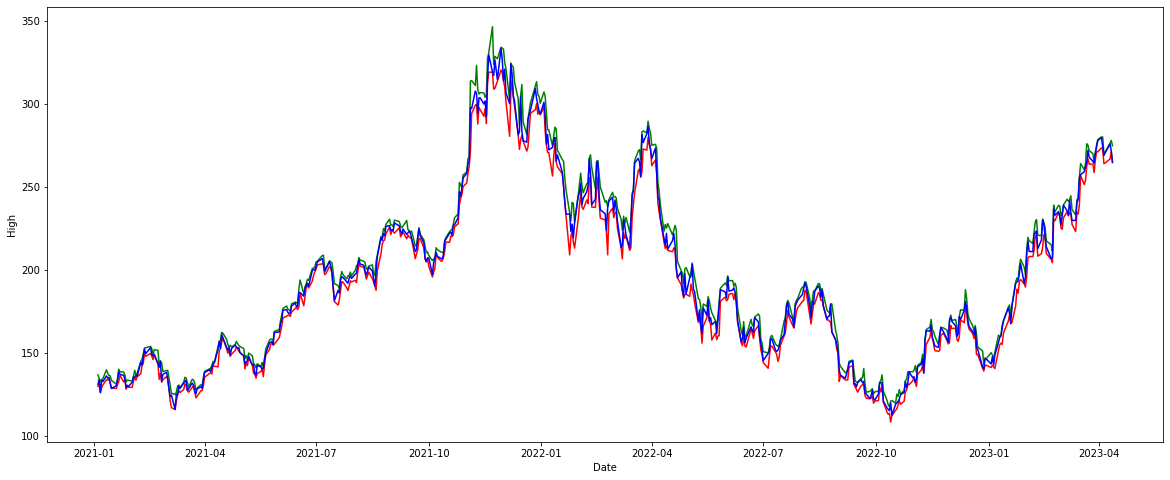

In [13]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(data=nvidia_2020, x="Date", y="High", color='g')
sns.lineplot(data=nvidia_2020, x="Date", y="Low", color='r')
sns.lineplot(data=nvidia_2020, x="Date", y="Adj Close", color='b')

,Date,Open,High,Low,Close,Adj Close,Volume
5522,2021-01-04,131.042496,136.524994,129.625000,131.134995,130.875916,56064000
5523,2021-01-05,130.997498,134.434998,130.869995,134.047501,133.782669,32276000
5524,2021-01-06,132.225006,132.449997,125.860001,126.144997,125.895790,58042400
5525,2021-01-07,129.675003,133.777496,128.865005,133.440002,133.176392,46148000
5526,2021-01-08,133.625000,134.210007,130.419998,132.767502,132.505219,29252800
...,...,...,...,...,...,...,...
6089,2023-04-05,268.290009,269.980011,263.950012,268.809998,268.809998,51501500
6090,2023-04-06,265.839996,270.799988,264.269989,270.369995,270.369995,39765400
6091,2023-04-10,268.230011,276.209991,266.690002,275.790009,275.790009,39527900
6092,2023-04-11,277.239990,277.899994,271.260010,271.690002,271.690002,31437800
